In [1]:
import tensorflow as tf

import os
import numpy as np
#os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd

import MBQuantSimul

In [2]:
def BasicBlock_MBQuantSimul(x, channel_size, name, strides=1, kernel_init="glorot_uniform", kernel_reg = None, tau=1.0):
    x_1 = x
    x_2 = x
    
    if strides != 1:
        #option_a
        x_2 = tf.keras.layers.MaxPool2D(1, strides=strides, padding="same", name=name+"_sc_maxpool"  )( tf.pad(x_2, ((0,0), (0,0), (0,0), (0, channel_size-x_2.shape[-1])), name=name+"_sc_optionA") )
        #option_b
        #x_2 = tf.keras.layers.Conv2D(channel_size, 1, strides=strides, padding='same', use_bias=False, name=name+"_sc_conv", kernel_initializer=INIT)(x_2)
        #x_2 = tf.keras.layers.BatchNormalization(name=name+"_sc_bn")(x_2)

    x_1 = MBQuantSimul.MBQuantSimulConv2D(channel_size, 3, tau=tau, strides=strides, padding="same", use_bias=False, name=name+"_conv1", kernel_initializer=kernel_init, kernel_regularizer=kernel_reg)(x_1)
    x_1 = tf.keras.layers.BatchNormalization(name=name+"_bn1")(x_1)
    x_1 = tf.keras.layers.Activation('relu', name=name+"_act1")(x_1)
    x_1 = MBQuantSimul.MBQuantActivation(tau=tau, name=name+"_act1_quantized")(x_1)
    
    x_1 = MBQuantSimul.MBQuantSimulConv2D(channel_size, 3, tau=tau, strides=1, padding="same", use_bias=False, name=name+"_conv2", kernel_initializer=kernel_init, kernel_regularizer=kernel_reg)(x_1)
    x_1 = tf.keras.layers.BatchNormalization(name=name+"_bn2")(x_1)
    
    x = tf.keras.layers.Add(name=name+"_add")([x_1, x_2])
    x = tf.keras.layers.Activation('relu', name=name+"_act2")(x)
    x = MBQuantSimul.MBQuantActivation(tau=tau, name=name+"_act2_quantized")(x)

    return x

def ResNet20_MBQuantSimul(input_shape=(32,32,3), classes=10, channel_sizes=16, kernel_init="glorot_uniform", kernel_reg=tf.keras.regularizers.L2(1e-4)):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    
    #pre
    x = MBQuantSimul.MBQuantSimulConv2D(channel_sizes, 3, tau=1.0, qconfig="distribution_aware", strides=1, padding="same", use_bias=False, name="pre_conv", kernel_initializer=kernel_init, kernel_regularizer=kernel_reg)(x)
    x = tf.keras.layers.BatchNormalization(name="pre_bn")(x)
    x = tf.keras.layers.Activation("relu",name="pre_act")(x)
    x = MBQuantSimul.MBQuantActivation(tau=1.0, name="pre_act_quantized")(x)

    #blocks_1
    x = BasicBlock_MBQuantSimul(x, channel_sizes, "blocks_1_1", strides=1, tau=1.0 )
    for i in range(1,3):
        x = BasicBlock_MBQuantSimul(x, channel_sizes, "blocks_1_"+str(i+1), strides=1, tau=1.0)

    #blocks_2
    x = BasicBlock_MBQuantSimul(x, channel_sizes*2, "blocks_2_1", strides=2, tau=1.0)
    for i in range(1,3):
        x = BasicBlock_MBQuantSimul(x, channel_sizes*2, "blocks_2_"+str(i+1), strides=1, tau=1.0)

    #blocks_3
    x = BasicBlock_MBQuantSimul(x, channel_sizes*4, "blocks_3_1", strides=2, tau=1.0)
    for i in range(1,3):
        x = BasicBlock_MBQuantSimul(x, channel_sizes*4, "blocks_3_"+str(i+1), strides=1, tau=1.0)
    
    #pred
    x = tf.keras.layers.GlobalAveragePooling2D(name="pred_gap")(x)
    x = MBQuantSimul.MBQuantDense(classes, name="pred_dense", tau=1.0, qconfig="distribution_aware", kernel_initializer=kernel_init, kernel_regularizer=kernel_reg)(x) #BIAS REGULARIZER X
    #x = tf.keras.layers.Dense(classes, name="pred_dense", kernel_initializer=kernel_init, kernel_regularizer=kernel_reg)(x) #BIAS REGULARIZER X
    x = tf.keras.layers.Activation("softmax", name="pred_out")(x)
    outputs = MBQuantSimul.MBQuantActivation(tau=1.0, name="pred_out_quantized")(x)
    
    return MBQuantSimul.MBQuantModel(inputs=inputs, outputs=outputs, name="ResNet20")
    #return tf.keras.Model(inputs=inputs, outputs=outputs, name="ResNet20")

In [3]:
model_pretrained = tf.keras.models.load_model("BASELINE_ResNet20_CIFAR10_2.h5")
model_quantized = ResNet20_MBQuantSimul()

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

y_train = tf.keras.utils.to_categorical(y_train)# tf.squeeze( tf.one_hot( y_train, y_train.max()+1 ) )
y_test = tf.keras.utils.to_categorical(y_test) #tf.squeeze( tf.one_hot( y_test, y_test.max()+1 ) )

x_train = x_train/255.0
x_test = x_test/255.0
x_mean = np.mean(x_train, axis=(0,1,2), keepdims=True)
x_std = np.std(x_train, axis=(0,1,2), keepdims=True)

x_train = (x_train - x_mean)/x_std
x_test = (x_test - x_mean)/x_std

#x_train = tf.cast(x_train, tf.float32)
#x_test = tf.cast(x_test, tf.float32)
#y_train = tf.cast(y_train, tf.float32)
#y_test = tf.cast(y_test, tf.float32)

In [5]:
for layer in model_pretrained.layers:
    if (type(layer) == tf.keras.layers.Conv2D) or (type(layer) == tf.keras.layers.Dense):
        layer_to = model_quantized.get_layer(layer.name)
        layer_to.kernel.assign( layer.kernel )
        if type(layer_to.bias) != type(None):
            layer_to.bias.assign( layer.bias )

    elif type(layer) == tf.keras.layers.BatchNormalization:
        model_quantized.get_layer(layer.name).set_weights( layer.get_weights() )

In [6]:
for idx, layer in enumerate(model_quantized.layers):
    if hasattr(layer,"qconfig") and layer.qconfig=="uniform":
        layer_name_to_find = layer.name.split("_quantized")[0]
        
        t_calc = tf.keras.Model(inputs=model_pretrained.layers[0].input, outputs=model_pretrained.get_layer(layer_name_to_find).output )(x_train).numpy().max()
        print("{} tau: {}".format(layer.name, t_calc))
        layer.tau.assign(t_calc)

pre_act_quantized tau: 23.411941528320312
blocks_1_1_act1_quantized tau: 27.65594482421875
blocks_1_1_act2_quantized tau: 30.236324310302734
blocks_1_2_act1_quantized tau: 23.997173309326172
blocks_1_2_act2_quantized tau: 48.182430267333984
blocks_1_3_act1_quantized tau: 23.007970809936523
blocks_1_3_act2_quantized tau: 38.236698150634766
blocks_2_1_act1_quantized tau: 19.169614791870117
blocks_2_1_act2_quantized tau: 27.926471710205078
blocks_2_2_act1_quantized tau: 15.065374374389648
blocks_2_2_act2_quantized tau: 29.794193267822266
blocks_2_3_act1_quantized tau: 18.395614624023438
blocks_2_3_act2_quantized tau: 49.784156799316406
blocks_3_1_act1_quantized tau: 29.81757354736328
blocks_3_1_act2_quantized tau: 62.60101318359375
blocks_3_2_act1_quantized tau: 14.856278419494629
blocks_3_2_act2_quantized tau: 63.32194137573242
blocks_3_3_act1_quantized tau: 20.320844650268555
blocks_3_3_act2_quantized tau: 73.78074645996094
pred_out_quantized tau: 1.0


In [7]:
def scheduler(epoch, lr):
    if epoch %30 == 0:
        return lr * 0.1
    else:
        return lr
    
LR_Scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
savename = "MBQuant_ResNet20_CIFAR10"
checkpoint_filepath = './' + savename + '/checkpoint_finetune-{epoch}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,save_best_only=False)

callback_bitwidth = MBQuantSimul.Callback_AdjustBitWidths()

#model_quantized.accumulate_grads = False
optim = tf.keras.optimizers.SGD(1e-4*10, momentum=0.9)
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model_quantized.compile(optimizer=optim, loss=loss_f, metrics=['accuracy'])

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True)
datagen.fit(x_train)

history = model_quantized.fit(datagen.flow(x_train, y_train, batch_size=128), validation_data=(x_test, y_test), epochs=100, callbacks=[model_checkpoint_callback, LR_Scheduler, callback_bitwidth])

hist_df = pd.DataFrame(history.history)
hist_df.to_csv(savename + '.csv'.format(savename), index=False)

Epoch 1/100
391/391 [==============================] - 45s 93ms/step - loss: 0.0231 - accuracy: 0.9926 - val_loss: 0.4802 - val_accuracy: 0.9189 - lr: 1.0000e-04
Epoch 2/100
391/391 [==============================] - 34s 86ms/step - loss: 0.0214 - accuracy: 0.9934 - val_loss: 0.4837 - val_accuracy: 0.9202 - lr: 1.0000e-04
Epoch 3/100
391/391 [==============================] - 32s 82ms/step - loss: 0.0194 - accuracy: 0.9939 - val_loss: 0.4821 - val_accuracy: 0.9209 - lr: 1.0000e-04
Epoch 4/100
391/391 [==============================] - 35s 88ms/step - loss: 0.0189 - accuracy: 0.9942 - val_loss: 0.4790 - val_accuracy: 0.9201 - lr: 1.0000e-04
Epoch 5/100
391/391 [==============================] - 35s 89ms/step - loss: 0.0190 - accuracy: 0.9944 - val_loss: 0.4886 - val_accuracy: 0.9190 - lr: 1.0000e-04
Epoch 6/100
391/391 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9952pre_act_quantized / 6 / 8
pre_act_quantized / 12 / 8
pre_act_quantized / 9 / 8
pre_act_quantiz

In [34]:
import matplotlib.pyplot as plt

In [9]:
"""
Finetune + LBA
"""

savename = "MBQuant_ResNet20_CIFAR10"
checkpoint_filepath = './' + savename + '/checkpoint_finetune-{epoch}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,save_best_only=False)

callback_bitwidth = MBQuantSimul.Callback_AdjustBitWidths()

#model_quantized.accumulate_grads = False
optim = tf.keras.optimizers.SGD(1e-4*10, momentum=0.9)
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model_quantized.compile(optimizer=optim, loss=loss_f, metrics=['accuracy'])

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True)
datagen.fit(x_train)

model_quantized.load_weights('./' + savename + '/checkpoint_finetune-29')

model_quantized.evaluate(x_test, y_test)

313/313 [==============================] - 8s 21ms/step - loss: 0.4308 - accuracy: 0.9007


[0.4308093786239624, 0.9006999731063843]

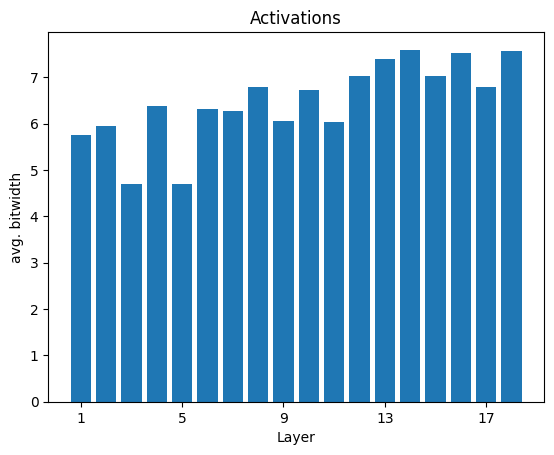

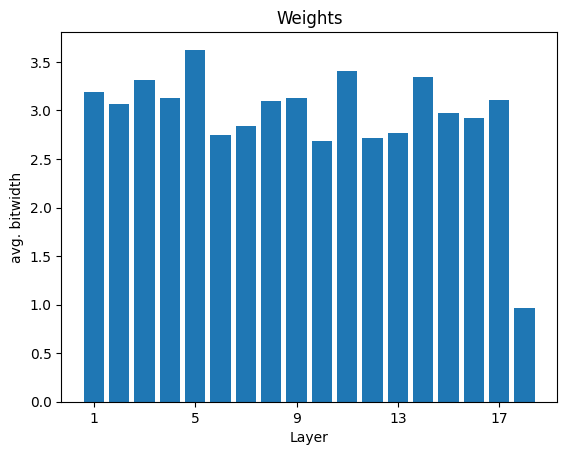

In [54]:
list_avg_wb = []
list_avg_ab = []
for layer in model_quantized.layers[5:-3]:
    if type(layer) == MBQuantSimul.MBQuantSimulConv2D or type(layer) == MBQuantSimul.MBQuantDense:
        #print(layer.name)
        #print(np.unique( layer.vec_bitwidth.numpy() ) )
        #print(layer.vec_bitwidth.numpy().mean())
    
        list_avg_wb.append( layer.vec_bitwidth.numpy().mean() )
    if type(layer) == MBQuantSimul.MBQuantActivation:
        list_avg_ab.append( layer.vec_bitwidth.numpy().mean() )
        
plt.bar(x = np.arange(len(list_avg_ab)), height=list_avg_ab)
plt.title("Activations")
plt.ylabel("avg. bitwidth")
plt.xlabel("Layer")
plt.xticks([0, 4, 8, 12, 16], [1, 5, 9, 13, 17])

plt.show()

plt.bar(x = np.arange(len(list_avg_wb)), height=list_avg_wb)
plt.title("Weights")
plt.ylabel("avg. bitwidth")
plt.xlabel("Layer")
plt.xticks([0, 4, 8, 12, 16], [1, 5, 9, 13, 17])

plt.show()

In [8]:
"""
Finetune
"""

savename = "MBQuant_ResNet20_CIFAR10"
checkpoint_filepath = './' + savename + '/checkpoint_finetune-{epoch}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,save_best_only=False)

callback_bitwidth = MBQuantSimul.Callback_AdjustBitWidths()

#model_quantized.accumulate_grads = False
optim = tf.keras.optimizers.SGD(1e-4*10, momentum=0.9)
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model_quantized.compile(optimizer=optim, loss=loss_f, metrics=['accuracy'])

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True)
datagen.fit(x_train)

model_quantized.load_weights('./' + savename + '/checkpoint_finetune-3')

model_quantized.evaluate(x_test, y_test)

313/313 [==============================] - 9s 21ms/step - loss: 0.4821 - accuracy: 0.9209


[0.48206210136413574, 0.9208999872207642]

In [7]:
"""
4bit / 32bit initial
"""

savename = "MBQuant_ResNet20_CIFAR10"
checkpoint_filepath = './' + savename + '/checkpoint_finetune-{epoch}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,save_best_only=False)

callback_bitwidth = MBQuantSimul.Callback_AdjustBitWidths()

#model_quantized.accumulate_grads = False
optim = tf.keras.optimizers.SGD(1e-4*10, momentum=0.9)
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model_quantized.compile(optimizer=optim, loss=loss_f, metrics=['accuracy'])

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True)
datagen.fit(x_train)

model_quantized.evaluate(x_test, y_test)


313/313 [==============================] - 10s 16ms/step - loss: 0.4003 - accuracy: 0.9073


[0.4002538025379181, 0.9072999954223633]

In [10]:
"""
4bit / 8bit initial
"""

savename = "MBQuant_ResNet20_CIFAR10"
checkpoint_filepath = './' + savename + '/checkpoint_finetune-{epoch}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,save_best_only=False)

callback_bitwidth = MBQuantSimul.Callback_AdjustBitWidths()

#model_quantized.accumulate_grads = False
optim = tf.keras.optimizers.SGD(1e-4*10, momentum=0.9)
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model_quantized.compile(optimizer=optim, loss=loss_f, metrics=['accuracy'])

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True)
datagen.fit(x_train)

model_quantized.evaluate(x_test, y_test)


313/313 [==============================] - 9s 20ms/step - loss: 0.5146 - accuracy: 0.9055


[0.5146205425262451, 0.9054999947547913]

In [8]:
"""
4bit / 4bit initial
"""

savename = "MBQuant_ResNet20_CIFAR10"
checkpoint_filepath = './' + savename + '/checkpoint_finetune-{epoch}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,save_best_only=False)

callback_bitwidth = MBQuantSimul.Callback_AdjustBitWidths()

#model_quantized.accumulate_grads = False
optim = tf.keras.optimizers.SGD(1e-4*10, momentum=0.9)
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model_quantized.compile(optimizer=optim, loss=loss_f, metrics=['accuracy'])

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True)
datagen.fit(x_train)

model_quantized.evaluate(x_test, y_test)


313/313 [==============================] - 9s 20ms/step - loss: 4.0581 - accuracy: 0.6383


[4.058104991912842, 0.6383000016212463]